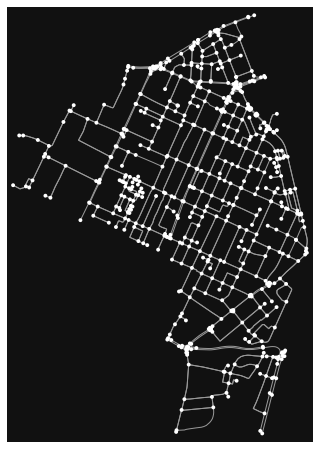

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [1]:
import osmnx as ox
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

state = ox.graph_from_place('kristiine, tallinn, estonia')
OSM_G = ox.graph_from_place('kristiine, tallinn, estonia', network_type='drive')
ox.plot_graph(OSM_G)

In [2]:
# define origin and desination locations 
origin_point = (59.400019,24.7094212) 
destination_point = (59.4262092,24.7019518)
# get the nearest nodes to the locations 
origin_node = ox.get_nearest_node(OSM_G, origin_point) 
destination_node = ox.get_nearest_node(OSM_G, destination_point)
# printing the closest node id to origin and destination points 
origin_node, destination_node

(11791126, 5868334870)

In [3]:
points_list = list(OSM_G.edges())

In [4]:
nodesNumber = OSM_G.number_of_nodes()
OSM_G.number_of_nodes(),OSM_G.number_of_edges()

(574, 1325)

In [5]:
nodes_list= []
for point in points_list:
    v,u = point[0],point[1]
    nodes_list.append(v)
    nodes_list.append(u)

In [6]:
nodes_set = set(nodes_list)

In [7]:
reverse_nodes_dict = dict(enumerate(nodes_set))
nodes_dict = dict(zip(nodes_set,range(0,nodesNumber)))

In [8]:
new_points_list = []
for point in points_list:
    v,u = point[0],point[1]
    newV, newU = nodes_dict[v],nodes_dict[u]
    new_node = (newV, newU)
    new_points_list.append(new_node)

In [9]:
nodes_dict[origin_node],nodes_dict[destination_node]

(290, 518)

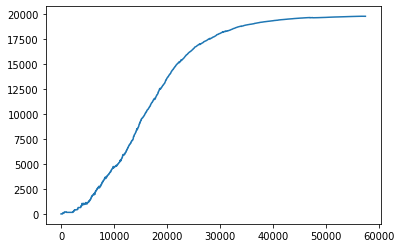

Best Route Based on Q Matrix:  [290, 288, 551, 282, 251, 281, 413, 266, 334, 22, 467, 206, 204, 217, 455, 219, 199, 237, 239, 177, 548, 258, 428, 141, 93, 36, 527, 528, 518]


In [10]:
G = nx.Graph()
G.add_edges_from(new_points_list)
R = np.matrix(np.ones(shape = (nodesNumber, nodesNumber)))
R *=-1
gamma = 0.8
initial_state = 1

def available_actions(state):
    startingNode_row = R[state, ]
    av_act = np.where(startingNode_row >= 0)[1]
    return av_act

def sample_next_action(available_act):
    next_action = int(np.random.choice(available_act, 1))
    return next_action

def update(Q,startingNode, action, gamma):
	    
    max_index = np.where(Q[action,]==np.max(Q[action,]))[1]
    
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    
    max_value = Q[action, max_index]
    
    Q[startingNode, action] = R[startingNode, action] + gamma *max_value
    
    if np.max(Q > 0):
        return(np.sum(Q/np.max(Q)*100))
    else:
        return (0)


def shortest_Path(origin,destination):
		
	for point in new_points_list:
	    if point[1] ==destination:
	        R[point] = 150
	    else:
	        R[point] = 0
	        
	    if point[0] == destination:
	        R[point[::-1]] = 150
	    else:
	        R[point[::-1]] = 0


	R[destination, destination] = 150

	Q = np.matrix(np.zeros([nodesNumber, nodesNumber]))
	
	available_act = available_actions(initial_state)
	action = sample_next_action(available_act)
	update(Q,initial_state, action, gamma)
	

	scores=[]
	for i in  range(nodesNumber*100):
	    startingNode = np.random.randint(0, int(Q.shape[0]))
	    available_act = available_actions(startingNode)
	    action = sample_next_action(available_act)
	    score = update(Q,startingNode, action, gamma)
	    scores.append(score)

	steps = [origin]
	current = origin
	while current != destination:
	    next_step_index = np.where(Q[current,]== np.max(Q[current,]))[1]
	    
	    if next_step_index.shape[0] > 1:
	        next_step_index = int(np.random.choice(next_step_index, size = 1))
	    else:
	        next_step_index = int(next_step_index)
	    
	    steps.append(next_step_index)
	    current = next_step_index

	return scores, steps


scores,steps = shortest_Path(nodes_dict[origin_node],nodes_dict[destination_node])
plt.plot(scores)
plt.show()
print('Best Route Based on Q Matrix: ',steps) 

In [11]:
Q_route = [reverse_nodes_dict[r] for r in steps]

In [12]:
#Next step is Visualization, Many thanks to https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873

In [13]:
# getting coordinates of the nodes
# we will store the longitudes and latitudes in following list 
long = [] 
lat = []  
for i in Q_route:
     point = OSM_G.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])

In [14]:
def plot_path(lat, long, origin_point, destination_point):
    

    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()

In [20]:
plot_path(lat, long, origin_point, destination_point)

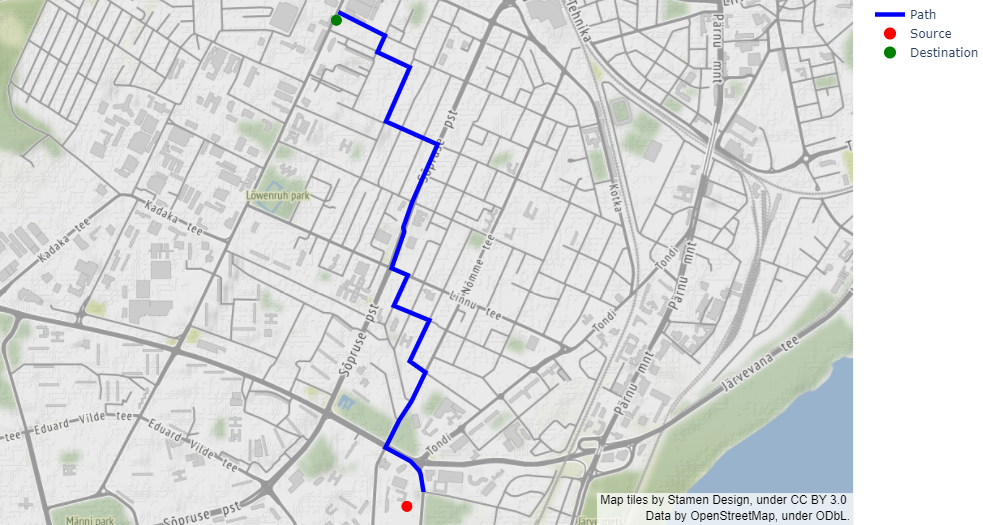

In [16]:
from IPython.display import Image
Image(filename='route.png')
# I added plotly statcic image to see the result without running the code!
# The result of running above block will be something like this.

In [17]:
# Next step is to use a deep learning instead of Q_Table!
# I should consider one way in the solution, But for now I will left it to work on the DQN part